In [1]:
import os
import re
import openai
import pandas as pd
import tiktoken
import numpy as np
from dotenv import load_dotenv
from openai import OpenAI
from langchain.schema import Document
from langchain_pinecone import PineconeVectorStore
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import Pinecone
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Necessary pip installation commands include:
- pip install openai
- pip install pandas
- pip install tiktoken
- pip install numpy
- pip install python-dotenv
- pip install langchain
- pip install langchain-pinecone
- pip install langchain-core
- pip install langchain-openai

#### <b>Note</b>: have a <b>.env</b> file already created for accessing API key

In [2]:
# retrieving API Key from OpenAI platform
load_dotenv()
# Initialize the tokenizer for GPT-3.5 Turbo and GPT-4
tokenizer = tiktoken.get_encoding("cl100k_base")
input_token_cost = ((1.00 / 1000000))
output_token_cost = ((2.00 / 1000000))
FINE_TUNED_TOXIC_DETECTION_API_KEY = os.getenv('FINE_TUNED_TOXIC_DETECTION_API_KEY')
pinecone_api_key = os.getenv('PINECONE_API_KEY')
pc_index = os.getenv('PINECONE_GPT')

In [3]:
# initializing Pinecone vector database instance
docSearch = Pinecone(
    index_name=pc_index,
    embedding=OpenAIEmbeddings()
)
# instantiating client with API key
fine_tuned = OpenAI(
    api_key=FINE_TUNED_TOXIC_DETECTION_API_KEY
)

C:\Users\elija\AppData\Local\Temp\ipykernel_14140\2326318028.py:2: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.3 and will be removed in 0.3.0. Use :class:`~PineconeVectorStore` instead.
  docSearch = Pinecone(


In [4]:
def remove_repetition(text, depth=0):
    # cap = 5
    # check = 0
    # split_line = line.split(' ')
    # new_split = []
    # curr = split_line[0]
    
    # for word in split_line:
    #     if word == curr:
    #         check = check + 1
    #     else:
    #         curr = word
    #         check = 0
            
    #     if check < cap:
    #         new_split.append(word)

    pattern = r'\b(\w+(?:\s+\w+)*)\b(?:\s+\1\b)+'
    new_text = re.sub(pattern, r'\1', text, flags=re.IGNORECASE)
    
    if new_text == text or depth > 10: 
        return new_text
    return remove_repetition(new_text, depth + 1)
    
    # return " ".join(new_split)

In [5]:
# appends one/few shot examples to evaluation prompt
def shot_additions(examples):
   evaluation_prompt = ''
   # Read the evaluation prompt from the text file with utf-8 encoding
   with open("../../data/text/rag_prompts/gpt-4-two-shot-prompt.txt", "r", encoding="utf-8") as file:
        evaluation_prompt += file.read() 
   count = 1
   for example in examples:
       # separates example key and values
       split_ex = example.split(' - ')
       comment = split_ex[0]
       label = split_ex[1]
       print(f'#{count} shot: {comment}')
       evaluation_prompt += '\n\nText: \"' + remove_repetition(comment) + "\"" + '\n\n' + label
       count += 1
   print(f'Shots added!')
   evaluation_prompt += '\n\nClassify the following comment:'
   return evaluation_prompt

In [6]:
# queries vector database for custom,
# with similar examples to user prompt
def rag_prompt(text):
    two_shots = []
    # queries Pinecone database
    search_results = docSearch.max_marginal_relevance_search(text, k=25, fetch_k=50)
    print(f'Search Results Length: {len(search_results)}')
    for i in range(len(search_results)):
        content = search_results[i].page_content
        # prevents repetition which will cause errors within OpenAI
        if i != 250:
            two_shots.append(content)
        # two valid examples found
        if len(two_shots) == 2:
            print(f'Two Shots Found!')
            break
    return shot_additions(two_shots)

In [7]:
def model_scores_and_metrics(tuned, original, tokens, finetuned=False):
    from sklearn.metrics import (
        roc_auc_score,
    )
    tuned = tuned[['Toxic']]
    predictions = original[['Toxic']]
    # comparing results of model to dataset
    compare = tuned['Toxic'] == original['Toxic']
    accuracy = compare.values.sum() / compare.size
    print(f"Accuracy: {accuracy * 100:.2f}%")
    if finetuned:
        f1 = f1_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
        precision = precision_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
        roc_auc_score = roc_auc_score(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))
        cm = confusion_matrix(tuned['Toxic'].astype(int), predictions['Toxic'].astype(int))

        print(f'F1: {f1}')
        print(f'Precision: {precision}')
        print(f'ROC AUC Score: {roc_auc_score}')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues')

    # token info
    input_cost = (tokens['Input'].sum() * input_token_cost)
    output_cost = (tokens['Output'].sum() * output_token_cost)
    total_cost = (tokens['Input'].sum() * input_token_cost) + (tokens['Output'].sum() * output_token_cost)
    total_tokens = tokens['Total'].sum()

    print(f"Input Tokens: {input_cost}")
    print(f"Output Tokens: {output_cost}")
    print(f"Total Cost: {total_cost}")
    print(f"Total Tokens: {total_tokens}")

In [8]:
# tests accuracy of chosen model against unique prompt and data
def accuracy_testing(data, evaluation_prompt, model, use_rag = False):
    # chooses columns of focus
    tuned = pd.DataFrame(columns=['Text', 'Toxic'])
    tokens = pd.DataFrame(columns=['Prompt', 'Input', 'Output', 'Total'])
    for index, row in data.iterrows():
        text = row['Text']
        print(f"Index: {index}")
        print(f'Text: {text}')
        print(f"Starting Completion at Index: {index}")
        completion = fine_tuned.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system", 
                    "content": evaluation_prompt if use_rag == False else rag_prompt(remove_repetition(text))
                },
                {
                    "role": "user",
                    "content": text
                }
            ]
        )
        print(f'Finished Completion {index}!')
        tuned.loc[index] = [text, completion.choices[0].message.content]
                # tokenize the string
        tokens_object = {
            'prompt': len(tokenizer.encode(evaluation_prompt)),
            'input': len(tokenizer.encode(row['Text'])),
            'output': len(tokenizer.encode(completion.choices[0].message.content))
        }
        total_tokens = tokens_object['prompt'] + tokens_object['input'] + tokens_object['output']
        tokens.loc[index] = [tokens_object['prompt'], tokens_object['input'], tokens_object['output'], total_tokens]
    # comparing results of model to dataset
    return tuned, data, tokens

In [9]:
sugarai = pd.read_csv('../../data/csv/sugar_ai_toxicity_evaluation_set.csv')
unintended_bias = pd.read_csv('../../data/csv/unintended_bias_toxicity_classification_set.csv')
sugarai['Toxic'] = sugarai['Toxic'].apply(lambda x: str(int(x)))
unintended_bias['Toxic'] = unintended_bias['Toxic'].apply(lambda x: str(int(x)))

In [10]:
evaluation_prompt = ''
# Read the evaluation prompt from the text file with utf-8 encoding
with open("../../data/text/fine_tuned_prompts/gpt-3-5-1106-two-shot-prompt.txt", "r", encoding="utf-8") as file:
    evaluation_prompt += file.read()

In [25]:
# testing accuracy of Sugar AI Toxicity Classification dataset on original model
tuned, original, tokens = accuracy_testing(sugarai, "Detect whether either is 1 for toxic or 0 for non-toxic", "gpt-3.5-turbo-1106")


Index: 0
Text: Youre full shitand food
Starting Completion at Index: 0
Finished Completion 0!
Index: 1
Text: Would accurate call shrimp gritz Looks fantastic
Starting Completion at Index: 1
Finished Completion 1!
Index: 2
Text: LIBERALS HATE AMERICA LIBERAL WORSHIP COMMUNISM LIBERALISM Severe Disease Mental Illness Find Cure Democrats LiberalLogic Leftists LibTard LiberalHypocrisy JoeBiden q7391
Starting Completion at Index: 2
Finished Completion 2!
Index: 3
Text: subhuman liar gone Billenda know truth
Starting Completion at Index: 3
Finished Completion 3!
Index: 4
Text: world worthy good hearted man Remarkable individual
Starting Completion at Index: 4
Finished Completion 4!
Index: 5
Text: Ondine actually great mix panik kalm
Starting Completion at Index: 5
Finished Completion 5!
Index: 6
Text: Ive called horrible things Warren supporters Theyre awful
Starting Completion at Index: 6
Finished Completion 6!
Index: 7
Text: Yes Give USED scarf love dearly noticed always compliment onand m

In [28]:

model_scores_and_metrics(tuned, original, tokens)

Input Tokens: 0.017145
Output Tokens: 0.059741999999999996
Total Cost: 0.076887
Total Tokens: 61986


In [29]:
# testing accuracy of Sugar AI Toxicity Classification dataset on fine-tuned model
tuned, original, tokens = accuracy_testing(sugarai, evaluation_prompt, "ft:gpt-3.5-turbo-1106:personal::AuiNCCpr")


Index: 0
Text: Youre full shitand food
Starting Completion at Index: 0
Finished Completion 0!
Index: 1
Text: Would accurate call shrimp gritz Looks fantastic
Starting Completion at Index: 1
Finished Completion 1!
Index: 2
Text: LIBERALS HATE AMERICA LIBERAL WORSHIP COMMUNISM LIBERALISM Severe Disease Mental Illness Find Cure Democrats LiberalLogic Leftists LibTard LiberalHypocrisy JoeBiden q7391
Starting Completion at Index: 2
Finished Completion 2!
Index: 3
Text: subhuman liar gone Billenda know truth
Starting Completion at Index: 3
Finished Completion 3!
Index: 4
Text: world worthy good hearted man Remarkable individual
Starting Completion at Index: 4
Finished Completion 4!
Index: 5
Text: Ondine actually great mix panik kalm
Starting Completion at Index: 5
Finished Completion 5!
Index: 6
Text: Ive called horrible things Warren supporters Theyre awful
Starting Completion at Index: 6
Finished Completion 6!
Index: 7
Text: Yes Give USED scarf love dearly noticed always compliment onand m

Accuracy: 90.48%
F1: 0.9096098953377736
Precision: 0.9579158316633266
ROC AUC Score: 0.9094284135958927
Input Tokens: 0.017145
Output Tokens: 0.001996
Total Cost: 0.019141000000000002
Total Tokens: 112953


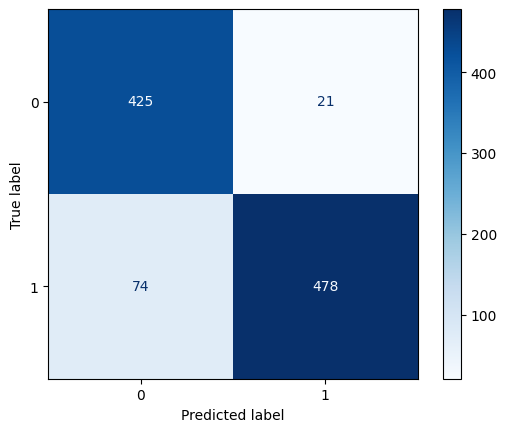

In [39]:
model_scores_and_metrics(tuned, original, tokens, True)

In [11]:
# testing accuracy of Unintended Sugar AI Toxicity Classification dataset on fine-tuned model with RAG
tuned, original, tokens = accuracy_testing(sugarai, evaluation_prompt, "ft:gpt-3.5-turbo-1106:personal::AuiNCCpr", True)


Index: 0
Text: Youre full shitand food
Starting Completion at Index: 0
Search Results Length: 25
Two Shots Found!
#1 shot: 1. Youre full shitand food
#2 shot: 2568. Hey ya doin fuck face u think safe huh ya SKANK ho need death nothing else really dislike existance think piece shit come home kill manlover hiding perish skank worthless dog shit backyard think come get GOD witness conduct crusade kind FUCK would change lci food fight article really hope die hole somewhere continue come back fucking ROT HELL longer needed earth wikipedia make like homosexual anal fuck drown cesspool bodily fluids really hope perish soon end life way want starting ideas Hang shoot head shotgun whatever wish hell even light fire hang dont make much mess one want spend much time WORTHLESS PIECE SHIT like go die commit suicide terminate existance would make happy hope GOD end life tomorrow even sunrise get blocked KNOW read thank longer needed thank managementgod
Shots added!
Finished Completion 0!
Index: 1
Te

Accuracy: 93.79%
F1: 0.9366053169734151
Precision: 0.9178356713426854
ROC AUC Score: 0.9385802953326816
Input Tokens: 0.017145
Output Tokens: 0.001996
Total Cost: 0.019141000000000002
Total Tokens: 112953


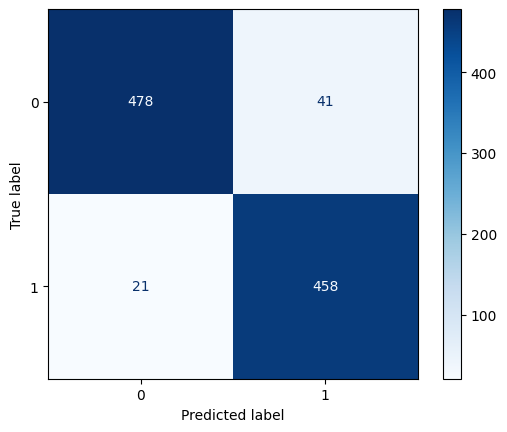

In [12]:
model_scores_and_metrics(tuned, original, tokens, True)

In [11]:
# testing accuracy of Unintended Bias Toxicity Classification dataset on original model
tuned, original, tokens = accuracy_testing(unintended_bias, "Detect whether either is 1 for toxic or 0 for non-toxic", "gpt-3.5-turbo-1106")


Index: 0
Text: Give us Pharrell Williams others caliber would really rock Lightening BOLT Olympic winner want talent trash
Starting Completion at Index: 0
Finished Completion 0!
Index: 1
Text: polling support among Canadians assisted suicide exceeds 80 Sadly folk choose end lives early still rather stuck without longer ironically opponents actually expediting deaths Research also shown lots people get approval actually choose go knowing option available gave peace mind
Starting Completion at Index: 1
Finished Completion 1!
Index: 2
Text: Even protective gear wear StephBand wont protect inattentive driver especially hit run drivers
Starting Completion at Index: 2
Finished Completion 2!
Index: 3
Text: great article suggest making friends people First Nations years ago able spend time living reserve Southern Ontario experience held good stead went China live twenty years Exposure another culture spirit service humanity unveils unknown aspects ones character thus engenders personal transfo

In [12]:
model_scores_and_metrics(tuned, original, tokens)

Accuracy: 0.50%
Input Tokens: 0.033055999999999995
Output Tokens: 0.07532
Total Cost: 0.108376
Total Tokens: 85716


In [13]:
# testing accuracy of Unintended Bias Toxicity Classification dataset on fine-tuned model
tuned, original, tokens = accuracy_testing(unintended_bias, evaluation_prompt, "ft:gpt-3.5-turbo-1106:personal::AuiNCCpr")


Index: 0
Text: Give us Pharrell Williams others caliber would really rock Lightening BOLT Olympic winner want talent trash
Starting Completion at Index: 0
Finished Completion 0!
Index: 1
Text: polling support among Canadians assisted suicide exceeds 80 Sadly folk choose end lives early still rather stuck without longer ironically opponents actually expediting deaths Research also shown lots people get approval actually choose go knowing option available gave peace mind
Starting Completion at Index: 1
Finished Completion 1!
Index: 2
Text: Even protective gear wear StephBand wont protect inattentive driver especially hit run drivers
Starting Completion at Index: 2
Finished Completion 2!
Index: 3
Text: great article suggest making friends people First Nations years ago able spend time living reserve Southern Ontario experience held good stead went China live twenty years Exposure another culture spirit service humanity unveils unknown aspects ones character thus engenders personal transfo

Accuracy: 71.80%
F1: 0.7134146341463414
Precision: 0.702
ROC AUC Score: 0.7182234608238836
Input Tokens: 0.033055999999999995
Output Tokens: 0.002
Total Cost: 0.035056
Total Tokens: 129056


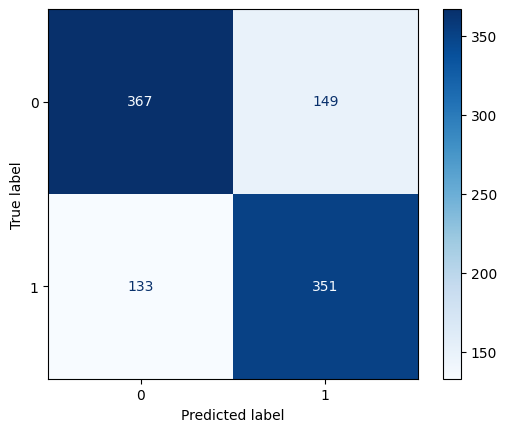

In [14]:
model_scores_and_metrics(tuned, original, tokens, True)

In [15]:
# testing accuracy of Unintended Bias Toxicity Classification dataset on fine-tuned model with RAG
tuned, original, tokens = accuracy_testing(unintended_bias, evaluation_prompt, "ft:gpt-3.5-turbo-1106:personal::AuiNCCpr", True)


Index: 0
Text: Give us Pharrell Williams others caliber would really rock Lightening BOLT Olympic winner want talent trash
Starting Completion at Index: 0
Search Results Length: 25
Two Shots Found!
#1 shot: 21608. loser got booted reality show Americas Got Talent nothing bouncing around half naked screeching violin moaning terrible falsetto article mention Millions saw handful saw Academy Award winning documentary snicker Gods sake6569812
#2 shot: 673. Mr Putin fairly elected leader large nation worked hard bring Olympic Games Sochi maintained dialogue US like North Korea Hitler admit analogy little bad denial Russian forces Ukraine wasnt best example conflict interest Putin says ethnic Russians Ukraine involved Russian military forces better example might governor recently pardoned son AmaryllisGardener address issue nominator RFA removing comments blocking others serious conflict interest since using administrative powers personal gain see nominating RFA succeed Still expressed sorro

Accuracy: 70.20%
F1: 0.6889352818371608
Precision: 0.66
ROC AUC Score: 0.7034354404679418
Input Tokens: 0.033055999999999995
Output Tokens: 0.002
Total Cost: 0.035056
Total Tokens: 129056


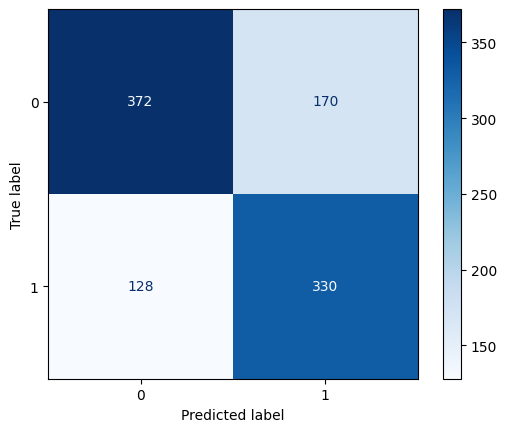

In [16]:
model_scores_and_metrics(tuned, original, tokens, True)